<a name="contenttable"></a>
### Table of Contents

0. [Context](#context)
1. [Loading Library and Data](#load)
2. [Exploratory Data Analysis](#eda)
    - [Data pre-processing](#dpp)
    - [Feature selection / renaming](#fse)
    - [Analysing text features](#atf)
3. [Data Processing](#dataprocess)
    - [Processing text features](#ptf)
    - [Feature engineering](#fe)
    - [Normalization](#normalization)
    - [PCA](#pca)
    - [Word2Vec Model](#w2vm)
    - [Text feature embedding](#tfe)
4. [Models](#model)
5. [Evaluation](#eval)
    - [Cross Validation](#cv)
    - [ROC AUC Plot](#rap)
6. [Conclusion](#eval)
    - [Improvements](#imp)
    - [Inferences](#inf)

[Back to Content Table](#contenttable)
<a name="context"></a>
# 0 - Context

In this project, the goal is to predict whether a user's post on Reddit will result in them receiving a free pizza from a fellow Reddit user. Reddit users frequently share personal stories and requests in the hope of receiving support or assistance from others. Understanding the factors that contribute to someone's request for pizza being fulfilled can show the dynamics of online kindness and empathy. By analyzing various features of these requests, such as the user's history, post content, and timing, we aim to build a predictive model that can anticipate whether a user's request will lead to an act of generosity.

The dataset used is from Tim Althoff et al. for their research paper : How to Ask for a Favor: A Case Study on the Success of Altruistic Requests (https://cs.stanford.edu/~althoff/raop-dataset/altruistic_requests_icwsm.pdf)

[Back to Content Table](#contenttable)
<a name="load"></a>
# 1 - Loading Library and Data

In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
import pandas as pd

import warnings
warnings.filterwarnings("ignore") 

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

import tensorflow_hub as hub
import tensorflow as tf

from collections import Counter

from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate, cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import NMF
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import QuantileTransformer


%matplotlib inline

To give a little bit of context to what the fields represent, here is the description from Kaggle ( RAOP means Random Acts of Pizza which is the name of the subreddit the request were put on ) :


`giver_username_if_known`: Reddit username of giver if known, i.e. the person satisfying the request ("N/A" otherwise).

`post_was_edited`: Boolean indicating whether this post was edited (from Reddit).

`request_id`: Identifier of the post on Reddit, e.g. "t3_w5491".

`request_number_of_comments_at_retrieval`: Number of comments for the request at time of retrieval.

`request_text`: Full text of the request.

`request_text_edit_aware`: Edit aware version of `request_text`. We use a set of rules to strip edited comments indicating the success of the request such as "EDIT: Thanks /u/foo, the pizza was delicous".

`request_title`: Title of the request.

`requester_account_age_in_days_at_request`: Account age of requester in days at time of request.

`requester_days_since_first_post_on_raop_at_request`: Number of days between requester's first post on RAOP and this request (zero if requester has never posted before on RAOP).

`requester_number_of_comments_at_request`: Total number of comments on Reddit by requester at time of request.

`requester_number_of_comments_in_raop_at_request`: Total number of comments in RAOP by requester at time of request.

`requester_number_of_posts_at_request`: Total number of posts on Reddit by requester at time of request.

`requester_number_of_posts_on_raop_at_request`: Total number of posts in RAOP by requester at time of request.

`requester_number_of_subreddits_at_request`: The number of subreddits in which the author had already posted in at the time of request.

`requester_received_pizza`: Boolean indicating the success of the request, i.e., whether the requester received pizza.

`requester_subreddits_at_request`: The list of subreddits in which the author had already posted in at the time of request.

`requester_upvotes_minus_downvotes_at_request`: Difference of total upvotes and total downvotes of requester at time of request.

`requester_upvotes_plus_downvotes_at_request`: Sum of total upvotes and total downvotes of requester at time of request.

`requester_username`: Reddit username of requester.

`unix_timestamp_of_request`: Unix timestamp of request (supposedly in the timezone of the user, but in most cases it is equal to the UTC timestamp -- which is incorrect since most RAOP users are from the USA).

`unix_timestamp_of_request_utc`: Unix timestamp of the request in UTC.

In [11]:
with open('../input/random-acts-of-pizza/train.json') as train:
    train_set = pd.DataFrame(json.load(train))
with open('../input/random-acts-of-pizza/test.json') as test:
    test_df = pd.DataFrame(json.load(test))
    
print("Train Dataset shape: ", train_set.shape)
print("Test Dataset shape: ", test_df.shape)

Train Dataset shape:  (4040, 32)
Test Dataset shape:  (1631, 17)


<a name="dpp"></a>
### Data Pre-Processing

We see that the test dataset features is a subset of that of the train dataset. So, we need to truncate the train dataset features. Because the test dataset has not the target feature, we need to not forget to add it also.

In [12]:
subset = train_set.columns.intersection(test_df.columns).union(['requester_received_pizza', 'request_text'])
train_df = train_set[subset].copy()
train_df.info()
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4040 entries, 0 to 4039
Data columns (total 19 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   giver_username_if_known                             4040 non-null   object 
 1   request_id                                          4040 non-null   object 
 2   request_text                                        4040 non-null   object 
 3   request_text_edit_aware                             4040 non-null   object 
 4   request_title                                       4040 non-null   object 
 5   requester_account_age_in_days_at_request            4040 non-null   float64
 6   requester_days_since_first_post_on_raop_at_request  4040 non-null   float64
 7   requester_number_of_comments_at_request             4040 non-null   int64  
 8   requester_number_of_comments_in_raop_at_request     4040 non-null   int64  
 9

,giver_username_if_known,request_id,request_text,request_text_edit_aware,request_title,requester_account_age_in_days_at_request,requester_days_since_first_post_on_raop_at_request,requester_number_of_comments_at_request,requester_number_of_comments_in_raop_at_request,requester_number_of_posts_at_request,requester_number_of_posts_on_raop_at_request,requester_number_of_subreddits_at_request,requester_received_pizza,requester_subreddits_at_request,requester_upvotes_minus_downvotes_at_request,requester_upvotes_plus_downvotes_at_request,requester_username,unix_timestamp_of_request,unix_timestamp_of_request_utc
0,N/A,t3_l25d7,Hi I am in need of food for my 4 children we a...,Hi I am in need of food for my 4 children we a...,Request Colorado Springs Help Us Please,0.000000,0.000000,0,0,0,0,0,False,[],0,0,nickylvst,1.317853e+09,1.317849e+09
1,N/A,t3_rcb83,I spent the last money I had on gas today. Im ...,I spent the last money I had on gas today. Im ...,"[Request] California, No cash and I could use ...",501.111100,0.000000,0,0,15,0,12,False,"[AskReddit, Eve, IAmA, MontereyBay, RandomKind...",34,116,fohacidal,1.332652e+09,1.332649e+09
2,N/A,t3_lpu5j,My girlfriend decided it would be a good idea ...,My girlfriend decided it would be a good idea ...,"[Request] Hungry couple in Dundee, Scotland wo...",0.000000,0.000000,0,0,0,0,0,False,[],0,0,jacquibatman7,1.319650e+09,1.319646e+09
3,N/A,t3_mxvj3,"It's cold, I'n hungry, and to be completely ho...","It's cold, I'n hungry, and to be completely ho...","[Request] In Canada (Ontario), just got home f...",6.518438,0.000000,36,0,1,0,4,False,"[AskReddit, DJs, IAmA, Random_Acts_Of_Pizza]",54,76,4on_the_floor,1.322855e+09,1.322855e+09
4,N/A,t3_1i6486,hey guys:\n I love this sub. I think it's grea...,hey guys:\n I love this sub. I think it's grea...,[Request] Old friend coming to visit. Would LO...,162.063252,101.606505,140,2,14,0,11,False,"[GayBrosWeightLoss, RandomActsOfCookies, Rando...",1121,1733,Futuredogwalker,1.373658e+09,1.373654e+09


<a name="fse"></a>
### Feature selection / renaming

We are going to drop a couple of columns  :
- `giver_username_if_known` is a value present in the test set but if we want to use our model later, we will not have this variable at the time of prediction. Although, it can bring knwoledge, for instance : Does the giver always have a similar username ?
- `request_text_edit_aware` in the train set does not indicate whether the post was edited before or after the pizza was given which is problematic because if it was edited after, the requester might have written text indicating the pizza was given and it would cause data leakage. So the train set will have just 'request_text' and the test set will have 'request_text_edit_aware' because 'request_text' is not present
- `unix_timestamp_of_request` is considered not consistent by Kaggle
- `request_id` is not visible for the user 
- `requester_upvotes_plus_downvotes_at_request` introduces redundacy with the column 'requester_upvotes_minus_downvotes_at_request'. We pick this one because it will be more centered around 0

In [13]:
def remove_columns_from_df(df, columns):
    for col in columns:
        df.drop(col, axis=1, inplace=True)
        
remove_columns_from_df(train_df, ['giver_username_if_known', 'request_text_edit_aware', 'unix_timestamp_of_request', 'requester_upvotes_plus_downvotes_at_request', 'request_id'])
remove_columns_from_df(test_df, ['giver_username_if_known', 'unix_timestamp_of_request', 'requester_upvotes_plus_downvotes_at_request', 'request_id'])

Renaming the features name for clear plots

In [14]:
shortname = {'requester_received_pizza'                            :'received_pizza',
             'request_text'                                        :'text',
             'request_text_edit_aware'                             :'text',
             'request_title'                                       :'title',
             'requester_username'                                  :'username',
             'requester_subreddits_at_request'                     :'subred_visited',
             'requester_upvotes_minus_downvotes_at_request'        :'up_minus_down' ,
             'requester_number_of_comments_in_raop_at_request'     :'num_comment_raop',
             'requester_account_age_in_days_at_request'            :'acc_age',
             'requester_number_of_posts_on_raop_at_request'        :'num_post_raop',
             'unix_timestamp_of_request_utc'                       :'utc_time',
             'requester_number_of_subreddits_at_request'           :'num_subred',
             'requester_number_of_posts_at_request'                :'num_post',
             'requester_number_of_comments_at_request'             :'num_comment',
             'requester_days_since_first_post_on_raop_at_request'  :'day_since_firstpost'}

train_df.rename(columns=shortname, inplace=True)
test_df.rename(columns=shortname, inplace=True)

[Back to Content Table](#contenttable)
<a name="eda"></a>
# 2 - Exploratory Data Analysis

### Some relevant plots

Lets start with the distribution of our numerical variables. We see that most of them follow the exponential distribution. It would be better to have normal distribution but because of the numerous zero values, we cannot transform it smoothly.

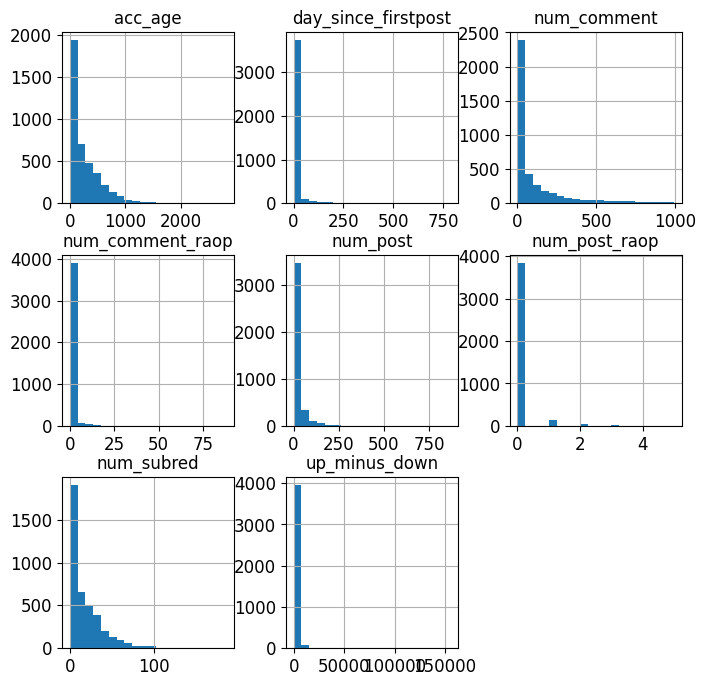

In [77]:
train_df_int_float_filtered = train_df.select_dtypes(include = ['float64', 'int64'])
train_df_int_float_filtered.hist(figsize=(8, 8), bins=20, xlabelsize=12, ylabelsize=12)
plt.show()

We see that there is still some unwanted peak, so we will not use this transformed dataframe

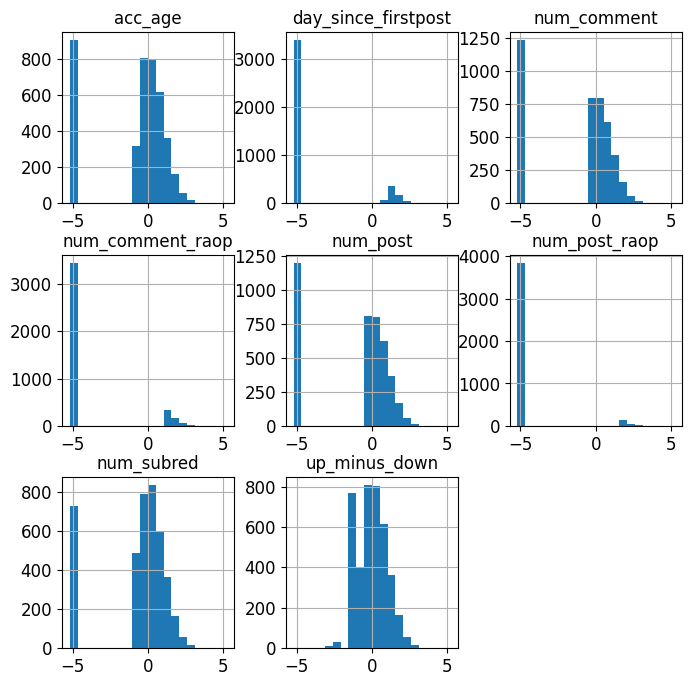

In [78]:
df = train_df_int_float_filtered.copy()
qt = QuantileTransformer(output_distribution='normal')
for col in df.columns:
    col_data = df[col].values.reshape(-1, 1)
    transformed_col = qt.fit_transform(col_data)
    df[col] = transformed_col.flatten()
df.hist(figsize=(8, 8), bins=20, xlabelsize=12, ylabelsize=12)
plt.show()

Correlation is often a good measure of multicollinearity and so we display the heatmap. Only one pair approaches 0.8 of correlation so overall it is pretty good. We will not remove variables.

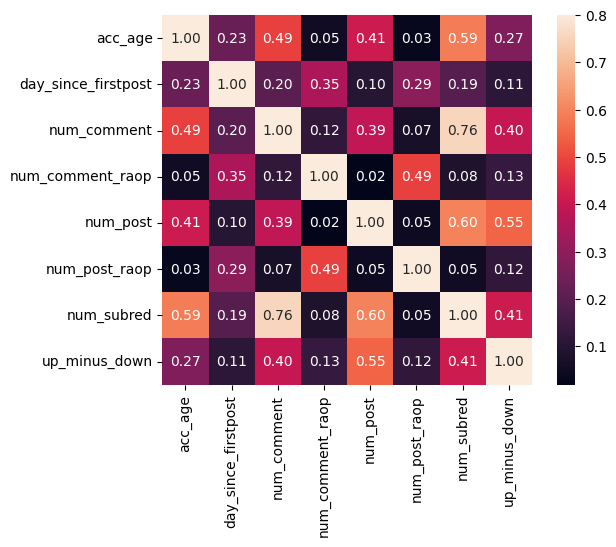

In [79]:
correlation_mat = train_df_int_float_filtered.corr()
sns.heatmap(correlation_mat, vmax=0.8, square=True, annot=True, fmt=".2f")
plt.show()

Dataset often come with outlier points. Outlier points could either indicate a special case or a defect during the capture of the data. This is an issue because obviously we do not want to train on incorrect data and we want our model to generalize well so training on rare data might downgrade performances. We make pair wise scatter plots to check any outliers. There is no outlandish points so we will keep everyone.

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


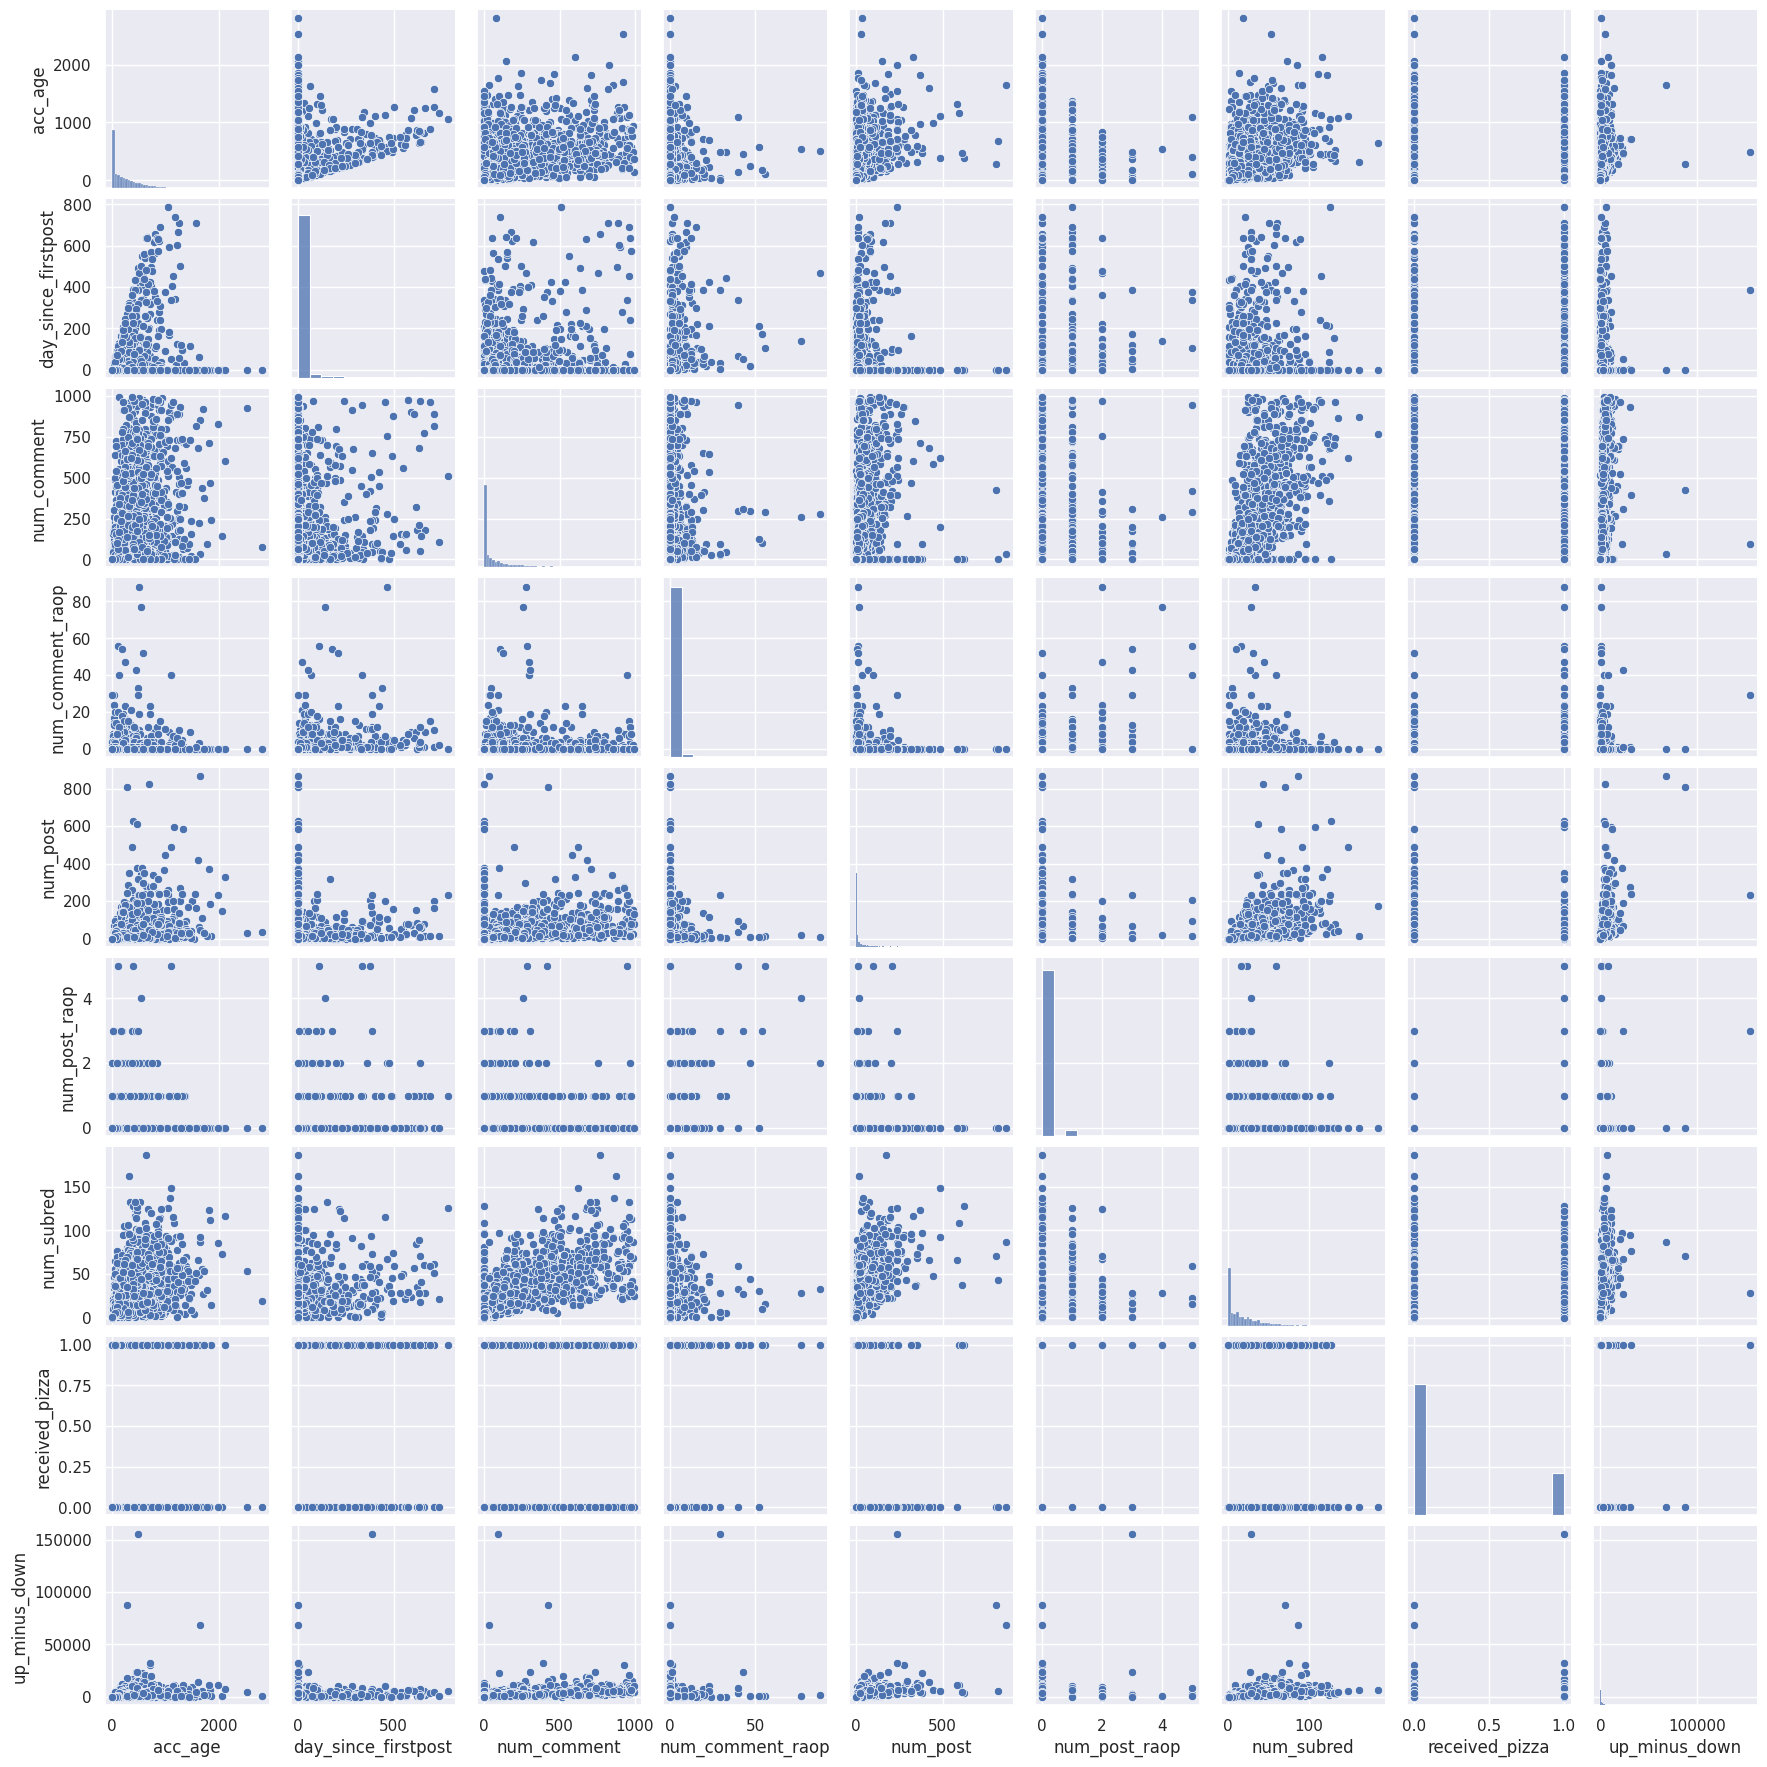

In [80]:
df = train_df.select_dtypes(include = ['float64', 'int64', 'bool'])
columns_excluded = ['month', 'day_of_week', 'day_of_month', 'hour']
columns_included = [col for col in df.columns if col not in columns_excluded]
sns.set()
sns.pairplot(df[columns_included], height = 2)
plt.show()

<a name="atf"></a>
### Analysing text feature

To get a grasp of what is working to get a pizza, we are going to compute the TF-IDF matrix (of the requests texts) which states the importance of each words in the corpus. Then, we will do NMF to extract from the TF-IDF the most frequent topics from the successful requests.

Here are the 5 first topics extracted from the data : 
- Hungriness
- Image 
- Family/Party
- Payback
- Money problem

It would be then interesting to add categorical variable stating if the request falls into one of those topics

In [15]:
def display_topics(model, feature_names, nb_top_words):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-nb_top_words - 1:-1]]))
        
nb_features = 700
nb_topics = 10
nb_top_words = 10

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=nb_features, stop_words='english')
pizza_received_rows = train_df[train_df['received_pizza'] == True]
tfidf = tfidf_vectorizer.fit_transform(pizza_received_rows['text'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

nmf = NMF(n_components=nb_topics, random_state=1, l1_ratio=.5, init='nndsvd').fit(tfidf)
nmf.fit(tfidf)
        
display_topics(nmf, tfidf_feature_names, nb_top_words)

Topic 0:
pizza really just like don right make want hungry going
Topic 1:
com http imgur jpg www picture edit reddit pic proof
Topic 2:
love pizza tonight title says family pretty pie surprise nice
Topic 3:
pay forward ll paycheck broke friday check soon promise comes
Topic 4:
help appreciate appreciated greatly thank need im edit willing food
Topic 5:
paid week account bank food friday house don days ramen
Topic 6:
thanks edit reading advance reddit pizza got dinner time good
Topic 7:
ve days got past ll weeks couple months rice unemployed
Topic 8:
work day today home time tomorrow night long lunch eat
Topic 9:
job food money new lost year time month car just


[Back to Content Table](#contenttable)
<a name="dataprocess"></a>
# 3 - Data Processing

<a name="ptf"></a>
### Processing text features

We could stem the words but the model we are going to use was trained on Wikipedia corpus which does not contain stemmed words so we will not do it. We will just remove stop words ( For example : "i", "me", "my", "myself" ... )

In [16]:
def remove_stopwords(text):
    #stemmer = SnowballStemmer("english")
    if isinstance(text, str):
        words = word_tokenize(text)
    elif isinstance(text, list):
        words = text
    #filtered_words = [stemmer.stem(word) for word in words if word.lower() not in stopwords.words("english")]
    filtered_words = [word for word in words if word.lower() not in stopwords.words("english")]
    return filtered_words

def df_stopwords_removal(df, text_columns):
    for text_feature in text_columns:
        df[text_feature] = df[text_feature].apply(remove_stopwords)

df_stopwords_removal(train_df, ['text', 'title'])
df_stopwords_removal(test_df, ['text', 'title'])

<a name="fe"></a>
### Feature engineering

UTC time is too general as a time variable, that is why we add some time variables to let the model have a better grasp of the time relations. One can wonder if one-hot encoding would be beneficial here. We will assume some time moment are more favourable than others to get a pizza.

In [17]:
def add_time_features_from_timestamp(df):
    df['utc_time'] = pd.to_datetime(train_df['utc_time'], unit='s')
    df['month'] = df['utc_time'].dt.month
    df['day_of_week'] = df['utc_time'].dt.dayofweek
    df['day_of_month'] = df['utc_time'].dt.day
    df['hour'] = df['utc_time'].dt.hour

add_time_features_from_timestamp(train_df)
add_time_features_from_timestamp(test_df)
train_df.drop('utc_time', axis=1, inplace=True) 
test_df.drop('utc_time', axis=1, inplace=True) 

To help the model understand what pattern the request text should follow to get a pizza, we will add 5 features. Each of these features represents the score of the request text regarding their respective topic. So the 

In [18]:
def calculate_narrative_feature(text, words):
    """
    Compute the "score" of a narrative symbolised by its words within a text
    """
    if len(text) == 0 or len(words) == 0:
        return 0
    return sum(text.count(word) for word in words)

def add_narrative_feature(df, topics):
    """
    Add categorical features indicating if a narative is present or not in the request text
    """
    new_df = df.copy()
    i = 0
    for words in topics:
        new_df['topic_' + str(i)] = df['text'].apply(lambda text: calculate_narrative_feature(text, words))
        i += 1
    return new_df

def extract_top_words(model, feature_names, nb_top_words, nb_topics):
    top_words_per_topic = []
    for topic_idx in range(nb_topics):
        topic = model.components_[topic_idx]
        top_words = [feature_names[i] for i in topic.argsort()[:-nb_top_words - 1:-1]]
        top_words_per_topic.append(top_words)
    return top_words_per_topic

nb_top_words = 25
nb_topics = 5
top_words_per_topic = extract_top_words(nmf, tfidf_feature_names, nb_top_words, nb_topics)

df_tr = add_narrative_feature(train_df, top_words_per_topic)
df_te = add_narrative_feature(test_df, top_words_per_topic)

<a name="w2vm"></a>
### Word2Vec Model

I will use the Wiki-words model from Google. It is a skipgram version of word2vec so it is lightweight and easy to understand

In [19]:
wiki_words = hub.load("https://www.kaggle.com/models/google/wiki-words/frameworks/TensorFlow2/variations/250-with-normalization/versions/1")

<a name="tfe"></a>
### Text feature embedding

In [20]:
def embed_text(text_data, model):
    """
    Requirement : The model used has to return tensors for the embedding
    Transform a string or list of string into an embedded numpy 1D vector
    """
    if isinstance(text_data, str):
        embeddings = model([text_data])
    elif isinstance(text_data, list):
        embeddings = model(text_data)
        if embeddings.shape[0] != 0:
            embeddings = tf.reduce_mean(model(text_data), axis=0, keepdims=True)
    if embeddings.shape[0] == 0:
        embeddings = tf.zeros((1, embeddings.shape[1]), dtype=tf.float32)
    return embeddings.numpy().squeeze()

def embed_text_features(df, columns, embed_function, embed_model):
    """
    Embed the text features of a dataframe. Change the columns in place
    """
    df_copy = df.copy()
    for col in columns:
        df_copy[col] = df_copy[col].apply(lambda text: embed_function(text, embed_model))
    return df_copy

def expand_vector_column(df, col, vector_size):
    """
    Expand a column having vector as values
    """
    expanded_cols = pd.DataFrame(df[col].apply(pd.Series))
    expanded_cols.columns = [f"{col}_{i+1}" for i in range(vector_size)]
    return expanded_cols

def expand_vectors_features(df, columns, vector_size, drop_old_col=True):
    """
    Expand all the features having vector as values
    """
    for col in columns:
        expanded_cols = expand_vector_column(df, col, vector_size)
        df = pd.concat([df, expanded_cols], axis=1)  # Concatenate horizontally
        if drop_old_col:
            df = df.drop(columns=[col])
    return df

def transform_df_for_model(df, text_columns, embed_function, embed_model):
    """
    Transform a dataframe with text features into a dataframe with only numerical and categorical features
    """
    df_embedded = embed_text_features(df, text_columns, embed_function, embed_model)
    vector_size = embed_model(['']).shape[1]
    df_expanded = expand_vectors_features(df_embedded, text_columns, vector_size)
    return df_expanded

The wiki-words is not trained on subreddit names and usernames so we will not use these text features

In [21]:
def drop_object_type_col(df):
    object_columns = df.select_dtypes(include=['object']).columns
    return df.drop(columns=object_columns)

text_columns = ['text', 'title']

# We create 2 dataset. One with the text features embedded, one without

narrative_embedded_tr, narrative_embedded_te = transform_df_for_model(df_tr, text_columns, embed_function=embed_text, embed_model=wiki_words), transform_df_for_model(df_te, text_columns, embed_function=embed_text, embed_model=wiki_words)
narrative_tr, narrative_te = transform_df_for_model(df_tr, [], embed_function=embed_text, embed_model=wiki_words), transform_df_for_model(df_te, [], embed_function=embed_text, embed_model=wiki_words)

narrative_embedded_tr, narrative_embedded_te = drop_object_type_col(narrative_embedded_tr), drop_object_type_col(narrative_embedded_te)
narrative_tr, narrative_te = drop_object_type_col(narrative_tr), drop_object_type_col(narrative_te)

<a name="normalization"></a>
## Normalization 

In [22]:
def normalize_df(df, df_test, categorical_col_to_exclude=None):
    """
    Normalize the int and float columns using StandardScaler
    """
    new_df = df.copy()
    new_df_test = df_test.copy()
    if not categorical_col_to_exclude:
        categorical_col_to_exclude = []
    columns_to_normalize = [col for col in df.columns if df[col].dtype in [int, float, 'float64', 'float32', 'int32'] and col not in categorical_col_to_exclude]
    scaler = StandardScaler()
    new_df[columns_to_normalize] = scaler.fit_transform(new_df[columns_to_normalize])
    new_df_test[columns_to_normalize] = scaler.transform(new_df_test[columns_to_normalize])
    return new_df, new_df_test

normalized_narrative_embedded_tr, normalized_narrative_embedded_te = normalize_df(narrative_embedded_tr, narrative_embedded_te)
normalized_narrative_tr, normalized_embedded_te = normalize_df(narrative_tr, narrative_te)

<a name="pca"></a>
## PCA

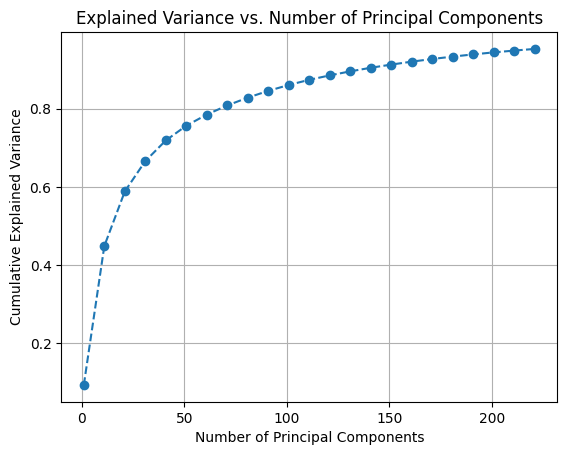

In [201]:
pca = PCA()
pca.fit(normalized_narrative_embedded_tr)
components_range = range(1, 230, 10)
cumulative_explained_variance = []

for n_components in components_range:
    pca.n_components = n_components
    pca.fit(normalized_narrative_embedded_tr)
    explained_variance = pca.explained_variance_ratio_
    cumulative_explained_variance.append(explained_variance.sum())

plt.plot(components_range, cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Principal Components')
plt.grid(True)
plt.show()

In [ ]:
normalized_narrative_embedded_tr.drop('received_pizza', axis=1, inplace=True)
normalized_narrative_tr.drop('received_pizza', axis=1, inplace=True)

In [94]:
pca = PCA(n_components=220)
X_nne = pca.fit_transform(normalized_narrative_embedded_tr)
X_ne = normalized_narrative_tr
X_nne_test = pca.transform(normalized_narrative_embedded_te)
X_ne_test = normalized_embedded_te

y = train_df['received_pizza']

print("Explained variance : ", pca.explained_variance_ratio_.sum())

Explained variance :  0.9528182460620851


In [87]:
y = train_df['received_pizza']
X_nne_train, X_nne_val, y_nne_train, y_nne_val = train_test_split(X_nne, y, test_size=0.2, shuffle=True, random_state=1)
X_ne_train, X_ne_val, y_ne_train, y_ne_val = train_test_split(X_ne, y, test_size=0.2, shuffle=True, random_state=1)

[Back to Content Table](#contenttable)
<a name="model"></a>
# 4 - Models

In [99]:
classifiers = [
    ("Logistic Regression", LogisticRegression()),
    ("Naive Bayes", GaussianNB()),
    ("Gradient Boosting", GradientBoostingClassifier()),
    ("K-Nearest Neighbors", KNeighborsClassifier()),
]

[Back to Content Table](#contenttable)
<a name="eval"></a>
# 5 - Evaluation

<a name="cv"></a>
### Cross Validation

One thing to keep in mind is that there is a lot more False than True in the target variable ( 75% False - 25% True ). Which means that, by taking a classifier that always classify as False, the accuracy will be 75% but it will performs terribly on new data. So, that is why using ROC AUC which is the area under the True Positive / False Positive Rates plot is crucial. We also peforms cross-validation to make the model performances more robust to the dataset splitting


In [107]:
n_folds = 5

def compute_roc_auc_acc(classifier, X, y):
    cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=1)
    scoring = ['accuracy', 'roc_auc'] 
    results = cross_validate(classifier, X, y, cv=cv, scoring=scoring)
    return results['test_accuracy'], results['test_roc_auc']

def compute_best_classifier(best_classifier, best_roc_auc, classifier_name, roc_auc_scores, narrative):
    avg_roc_auc = roc_auc_scores.mean()
    if avg_roc_auc > best_roc_auc:
        best_classifier = (classifier_name, avg_roc_auc, narrative)
        return best_classifier, avg_roc_auc
    return best_classifier, best_roc_auc

narrative_dic = {0: "no text feature embedding", 1: "text feature embedding"}
best_classifier = ("None", 0, 0)
best_roc_auc = 0

for classifier_name, classifier in classifiers:
    
    accuracy_scores_nne, roc_auc_scores_nne = compute_roc_auc_acc(classifier, X_nne, y)
    best_classifier, best_roc_auc = compute_best_classifier(best_classifier, best_roc_auc, classifier_name, roc_auc_scores_nne, 1)
    
    accuracy_scores_ne, roc_auc_scores_ne = compute_roc_auc_acc(classifier, X_ne, y)
    best_classifier, best_roc_auc = compute_best_classifier(best_classifier, best_roc_auc, classifier_name, roc_auc_scores_ne, 0)
    
    print(f"\t\t{classifier_name} Results:")
    print("----- Narrative + Embedded -----\t----- Narrative -----")
    print(f"Accuracy: {accuracy_scores_nne.mean():.3f}\t\t\tAccuracy: {accuracy_scores_ne.mean():.3f}")
    print(f"ROC AUC: {roc_auc_scores_nne.mean():.3f}\t\t\tROC AUC: {roc_auc_scores_ne.mean():.3f}")
    print("")

print("")
print("The best classifier is the", best_classifier[0], "with an average ROC AUC of:", best_classifier[1], "using", narrative_dic[best_classifier[2]])

		Logistic Regression Results:
----- Narrative + Embedded -----	----- Narrative -----
Accuracy: 0.741			Accuracy: 0.762
ROC AUC: 0.615			ROC AUC: 0.627

		Naive Bayes Results:
----- Narrative + Embedded -----	----- Narrative -----
Accuracy: 0.535			Accuracy: 0.728
ROC AUC: 0.600			ROC AUC: 0.633

		Gradient Boosting Results:
----- Narrative + Embedded -----	----- Narrative -----
Accuracy: 0.753			Accuracy: 0.757
ROC AUC: 0.604			ROC AUC: 0.660

		K-Nearest Neighbors Results:
----- Narrative + Embedded -----	----- Narrative -----
Accuracy: 0.683			Accuracy: 0.731
ROC AUC: 0.536			ROC AUC: 0.559


The best classifier is the Gradient Boosting with an average ROC AUC of: 0.6602649312052461 using no text feature embedding


<a name="rap"></a>
### ROC AUC Plot


|    Confusion Matrix  | Actual Positive | Actual Negative |
|:-------------:|:---------------:|:---------------:|
| Predicted Positive | True Positive (TP) | False Positive (FP) |
| Predicted Negative | False Negative (FN) | True Negative (TN)  |

Confusion matrix :
 [[2946  100]
 [ 885  109]]


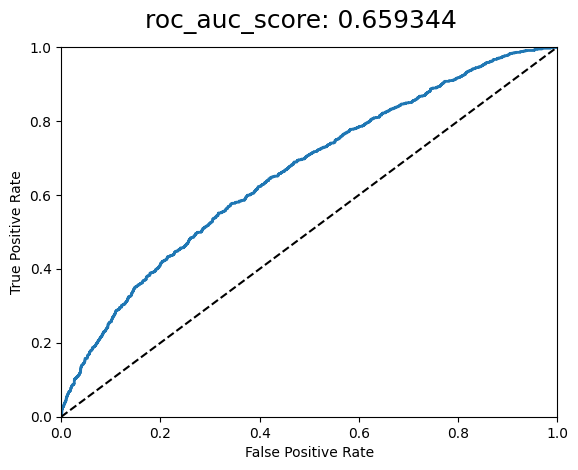

In [124]:
logistic_clf = GradientBoostingClassifier()  

cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=1)
y_scores = cross_val_predict(logistic_clf, X_ne, y, cv=cv, method='predict_proba')[:, 1]
conf_matrix = confusion_matrix(y, y_scores > 0.5)
print("Confusion matrix :\n", conf_matrix)

fpr, tpr, thresholds = roc_curve(y, y_scores)
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.figtext(.5, .92, 'roc_auc_score: %f' % roc_auc_score(y, y_scores), fontsize=18, ha='center')
plt.show()

[Back to Content Table](#contenttable)
<a name="conclusion"></a>
# 6 - Conclusion

<a name="imp"></a>
### Improvements

The text features embedding do not really contribute to the model performances. It might be because the models used were too elementary to detect complex patterns in the requester's text. Using CNN or RNN might improve significantly the performances when using text embedding. Moreover, the features increase dramatically with the embedding which does not help some of the models used.

More relevant features could have been added. For instance : was the requester polite / using images, text length ... 

<a name="inf"></a>
### Inferences

The topics : 

- Hungriness
- Image 
- Family/Party
- Payback
- Money problem

that we have chosen effectively help the model to decide whether a requester will receive a pizza. We can then infer that :

- Talking about personal problem can trigger empathy in the reader and make him prone to give pizza
- Bring the reader into the intimate circle by asking for a pizza for an intimate reason like a surprise birthday, a party, a gift
- Construct a trusting relation by promising a payback or by showing images proving personal struggles

We can also infer that time matter. More analysis could be made to pinpoint which timeframes are really effective.
